In [3]:
#Libraries
import streamlit as st
import pandas as pd
import pandas_ta as ta
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from binance.client import Client
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

/Users/brandonamarasingam/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Part 1

In [4]:
#Read in data
#https://github.com/binance/binance-public-data/

client = Client()

# Set the start date and current date
start_date = "1 Jan, 2020"
end_date = datetime.now().strftime("%d %b, %Y")

# Fetch the klines/candlestick data
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, start_date, end_date)

# Create a DataFrame
df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Set timestamp as index
df.set_index('timestamp', inplace=True)

# Convert relevant columns to float
float_columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
df[float_columns] = df[float_columns].astype(float)

In [5]:
df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
timestamp,,,,,,,,,,,
2020-01-01,7195.24,7255.0,7175.15,7200.85,16792.388165,1577923199999,1.212145e+08,194010.0,8946.955535,6.459779e+07,0
2020-01-02,7200.77,7212.5,6924.74,6965.71,31951.483932,1578009599999,2.259823e+08,302667.0,15141.611340,1.070608e+08,0
2020-01-03,6965.49,7405.0,6871.04,7344.96,68428.500451,1578095999999,4.950986e+08,519854.0,35595.496273,2.577131e+08,0
2020-01-04,7345.00,7404.0,7272.21,7354.11,29987.974977,1578182399999,2.198742e+08,279370.0,16369.382248,1.200351e+08,0
2020-01-05,7354.19,7495.0,7318.00,7358.75,38331.085604,1578268799999,2.848487e+08,329209.0,19455.369564,1.446001e+08,0


In [6]:
df['returns'] = np.log(df.close.pct_change() + 1)
df['direction'] = [1 if i>0 else 0 for i in df.returns]

In [7]:
def lagit(df, lags):
    names = []
    for i in range(1, lags+1):
        df['Lag_'+str(i)] = df['returns'].shift(i)
        df['Lag_'+str(i)+'_dir'] = [1 if j>0 else 0 for j in df['Lag_'+str(i)]]
        names.append('Lag_'+str(i)+'_dir')
    return names

In [8]:
dirnames = lagit(df, 2)

In [9]:
df.dropna(inplace=True)

In [10]:
model = LogisticRegression()

In [11]:
df[dirnames]

,Lag_1_dir,Lag_2_dir
timestamp,,
2020-01-04,1,0
2020-01-05,1,1
2020-01-06,1,1
2020-01-07,1,1
2020-01-08,1,1
...,...,...
2024-07-12,0,0
2024-07-13,1,0
2024-07-14,1,1


In [12]:
model.fit(df[dirnames], df['direction'])

LogisticRegression()

In [13]:
df['prediction_Logit'] = model.predict(df[dirnames])

In [14]:
df['strat_Logit'] = df['prediction_Logit'] * df['returns']

In [15]:
np.exp(df[['returns', 'strat_Logit']].sum())

returns        8.771457
strat_Logit    8.985323
dtype: float64

<Axes: xlabel='timestamp'>

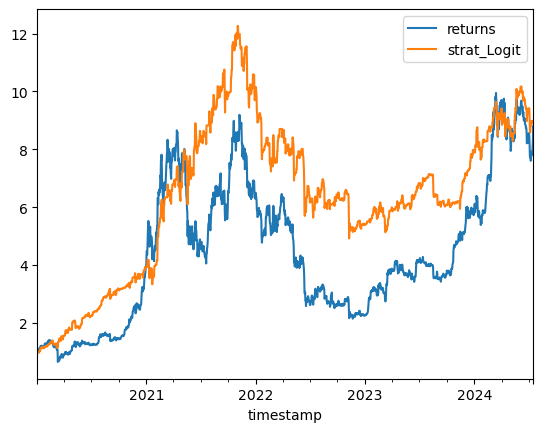

In [16]:
np.exp(df[['returns', 'strat_Logit']].cumsum()).plot()

In [17]:
train, test = train_test_split(df, test_size=0.2, shuffle=False, random_state=42)
train = train.copy()
test = test.copy()

model = LogisticRegression()

model.fit(train[dirnames], train['direction'])

LogisticRegression()

In [18]:
test['prediction_Logit'] = model.predict(test[dirnames])

In [19]:
test['strat_Logit'] = test['prediction_Logit']*test['returns']

In [20]:
np.exp(test[['returns', 'strat_Logit']].sum())

returns        2.468428
strat_Logit    1.409771
dtype: float64

<Axes: xlabel='timestamp'>

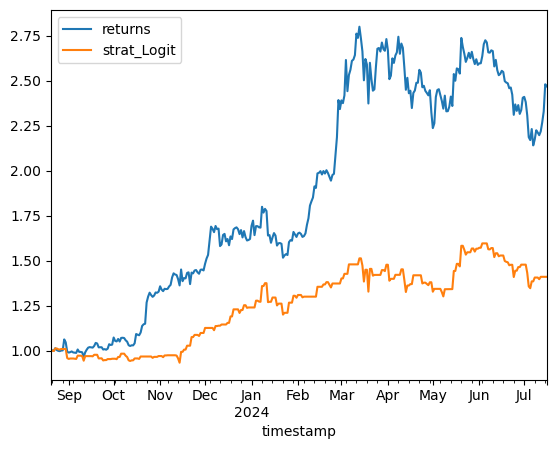

In [21]:
np.exp(test[['returns', 'strat_Logit']].cumsum()).plot()

In [22]:
metrics.confusion_matrix(test['direction'], test['prediction_Logit'])

array([[89, 68],
       [87, 88]])

In [24]:
print(metrics.classification_report(test['direction'], test['prediction_Logit']))

              precision    recall  f1-score   support

           0       0.51      0.57      0.53       157
           1       0.56      0.50      0.53       175

    accuracy                           0.53       332
   macro avg       0.53      0.53      0.53       332
weighted avg       0.54      0.53      0.53       332

